# License Plate Recognition Surveillance in Oakland

## 1. Introduction

**In this assignment, we will be working with Automated License Plate Reader (ALPR) data from the Oakland, CA Police Department.**

The data we will be using in this assignment has previously been used in Data 8 to teach a lesson about privacy. In that lesson, students were introduced to Oakland ALPR data and used the data to track the whereabouts of a former Mayor of Oakland. Students thus considered some of the privacy concerns that ALPR data raise, including giving those with access to the data the ability to determine where people live, work, and what they do in their free time. One of the conclusions of the privacy lecture was that data collected for one purpose (such as to “fight crime”) can reveal a lot more than initially intended. **We carry this same objective over to this new assignment, in which we aim to introduce you to the social and historical contexts of Automated License Plate Reader data, and how the collection and use of this data distributes risks among different population groups unevenly.**

### A. Background



Automated License Plate Readers, which are usually mounted on police cars, capture digital license plate data and images for law enforcement purposes (Policy Manual). In particular, the Oakland Police Department writes in their ALPR policy manual that the data can be used for “identifying stolen or wanted vehicles, stolen license plates and missing persons. It may also be used to gather information related to active warrants, suspect interdiction and stolen property recovery” (Policy Manual). As of 2015, Oakland PD operated 33 license plate readers, each of which can scan up to 60 license plates per second (Ars Technica). Thus, Oakland PD stores millions of records, of which only a small portion are associated with a criminal investigation (ACLU). While Oakland PD says that its data collection and storage procedures adhere to privacy rights, including purging unused data after 6 months and restricting the sharing of data, it is crucial to note that millions of Oakland PD license plate records are available online – this is how we found the data for this assignment (Policy Manual). In addition, while the Supreme Court has ruled that cars on public roads do not have a reasonable expectation of privacy, it is important to remember that “reasonable suspicion or probable cause is not required before using an ALPR to scan license plates or collect data” (Policy Manual).  

### B. Introductory Questions

**Q0a:** What is one reason that Oakland PD gives for collecting ALPR data? 

*Answer here*

**Q0b:** What is one drawback to collecting and using ALPR data?

*Answer here*

## 2. ALPR Data

In [1]:
!apt install libspatialindex-dev;
!pip install rtree;
!pip install geopandas;
!pip install folium;

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [1]:
import warnings
warnings.filterwarnings('ignore')

from datascience import *
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium

from sklearn.preprocessing import normalize

%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

All available ALPR data can be found [here](https://data.oaklandca.gov/browse?q=alpr&sortBy=relevance). We are working with data from (4/1/14 - 5/31/14). This is what was recent when we it was downloaded for Data 8. While the data is not the most recent now, you can see how the OPD policy of deleting data after 6 months can be circumvented by private parties accessing and storing the data seperately from the city's databases.

In [3]:
alpr = Table().read_table("/content/drive/MyDrive/Colab Notebooks/ALPR/lprs-data.csv")
alpr

**Q1**: What can we learn from the table `alpr`? What do the columns represent, and what do the rows represent?

*Answer here*

**Q2**: How many license plate readings are in our data from 4/1/14 - 5/31/14? follow-up... 

*Answer here*

# **Cleaning and preparing our data** 

The ALPR data contains some useful attributes for visualizing and analyzing. 
As a first step in cleaning `alpr`We would like to relabel our columns to make them easier to work with and sort the ALPR data by Timestamp in chronological order. We also need to split our location into seperate latitude and longitude columns so that we can leverage spatial libraries. 

Consider the following column names in our final result: 'Plate', 'Timestamp', 'Latitude', and 'Longitude'.

In [3]:
def getlatitude(s):
    before, after = s.split(',') # Break it into two parts
    latstring = before[1:] # Get rid of the annoying '('
    return float(latstring) # Convert the string to a number
def getlongitude(s):
    before, after = s.split(',') # Break it into two parts
    longstring = after[1:-1] # Get rid of the ' ' and the ')'
    return float(longstring) # Convert the string to a number

In [4]:
# Relabel columns 
alpr = alpr.relabeled("red_VRM", "Plate").relabeled("red_Timestamp", "Timestamp")

# Split Location to 'Latitude' and 'Longitude' columns
alpr = alpr.with_columns("Latitude", alpr.apply(getlatitude, "Location 1"), "Longitude", alpr.apply(getlongitude, "Location 1")).drop("Location 1")

# Sort the LPRS data by Timestamp in chronological order
alpr = alpr.sort("Timestamp", descending=False)

In [5]:
alpr

Plate,Timestamp,Latitude,Longitude
6LWL396,04/01/2014 01:00:00 PM,37.8048,-122.251
4DGR470,04/01/2014 01:00:00 PM,37.7938,-122.253
6RIP575,04/01/2014 01:00:00 PM,37.8047,-122.251
4ZDX994,04/01/2014 01:00:00 PM,37.8046,-122.251
6XJW220,04/01/2014 01:00:00 PM,37.8046,-122.251
6J44213,04/01/2014 01:00:00 PM,37.8042,-122.252
6B03075,04/01/2014 01:00:00 PM,37.8042,-122.252
4PKP608,04/01/2014 01:00:00 PM,37.794,-122.255
4RPB940,04/01/2014 01:00:00 PM,37.7939,-122.255
5MBD011,04/01/2014 01:00:00 PM,37.7921,-122.248


## 3. Exploratory Data Analysis on ALPR Data

### Distributions

In [6]:
plate_counts = alpr.group("Plate").sort("count", descending=True).relabel("count", "times seen")

In [7]:
plate_counts

Plate,times seen
L7IAB,98
1426010,86
1426174,75
1426006,63
1328327,62
1426032,59
PARKING,53
1275270,52
4EKC358,51
1426202,50


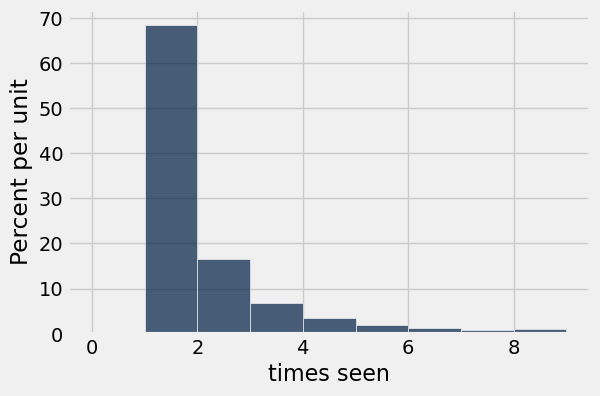

In [8]:
plate_counts.hist('times seen', bins=np.arange(0, 10, 1))

In [34]:
plate_counts.boxplot('times seen') #doesnt work

TypeError: ignored

In [9]:
plate_counts_above_10 = plate_counts.where("times seen", are.above_or_equal_to(10)).num_rows

In [10]:
plate_counts_above_10

2117

**Q:** Can we compare plate counts for each unique plate to the number of registered vehicles in Oakland? What are the implications of this result? What is the gap between these two pieces of information?

In [11]:
#Append time seen count to alpr object already in ALPR object, why have multiple objects instead of filtering ALPR?5
alpr = alpr.join("Plate", plate_counts, "Plate")
alpr.show(10)

Plate,Timestamp,Latitude,Longitude,times seen
0008ZH1,04/02/2014 11:46:00 PM,37.8041,-122.299,3
0008ZH1,05/11/2014 09:45:00 PM,37.8046,-122.299,3
0008ZH1,05/20/2014 09:48:00 PM,37.8041,-122.299,3
00096B1,04/14/2014 09:02:00 AM,37.7905,-122.218,1
000CA,04/10/2014 11:24:00 PM,37.7895,-122.245,5
000CA,04/28/2014 11:04:00 AM,37.7898,-122.244,5
000CA,04/28/2014 11:08:00 AM,37.7896,-122.245,5
000CA,05/06/2014 08:34:00 AM,37.7872,-122.239,5
000CA,05/28/2014 04:59:00 PM,37.8116,-122.266,5
000EK,04/06/2014 01:41:00 PM,37.8035,-122.234,1


In [12]:
alpr.sort("Timestamp").show(10)

Plate,Timestamp,Latitude,Longitude,times seen
3BEF704,04/01/2014 01:00:00 PM,37.7918,-122.248,1
3WSX024,04/01/2014 01:00:00 PM,37.7932,-122.254,1
3ZZA909,04/01/2014 01:00:00 PM,37.8028,-122.254,4
4CXP907,04/01/2014 01:00:00 PM,37.8013,-122.254,1
4DGR470,04/01/2014 01:00:00 PM,37.7938,-122.253,6
4NEZ422,04/01/2014 01:00:00 PM,37.8018,-122.254,1
4PKP608,04/01/2014 01:00:00 PM,37.794,-122.255,3
4RPB940,04/01/2014 01:00:00 PM,37.7939,-122.255,2
4ZDX994,04/01/2014 01:00:00 PM,37.8046,-122.251,14
5KZH517,04/01/2014 01:00:00 PM,37.7933,-122.254,1


### Maps 

Most visualizations in data science are about seeing values in a statistically meaningful way. When your data has the added dimension of space, you can display this complexity using maps. As a visualization, mapped data brings the meaning of place into the conversationtion. Since people usually have an attachment to certain places and an understanding of the world that includes a spatial component, maps can be a great way to make data more interesting and meaningful. Many phenomenon are spatial by nature, giving it spatial context can help.  

There are non-spatial libraries you can use to plot latitude and longitude as x and y on an axis but for the most part you want to use a spatial libray for ease of use and added functionality. We will use the folium package because it has a lot of neat functions that make exploration easy. 

The first step to using a spatial library is to make your dataset a spatial object. We can use 'type()' to see what kind of object our data is currently. We first opened it using the datascience notebook.  

Lets use some maps to visualize the data. First, let's take a look at the first 1000 readings, starting on 4/01/2014.

The following are functions we use to display maps. You are not required to learn how to use them, but the docstring explains the workings.

It can be helpful to look at your data the way the computer sees it before modeling a social phenomenon with a geographic component

**Q:** The Open Data Portal the city of Oakland uses has a [visualization tool](https://data.oaklandca.gov/d/mqhr-9st7/visualization). Visit the page, Did you find this tool helpful? what additional functionalities would you want from this tool?

Before we can bring our data into a GIS (Geographic Information System)
in python we need to make sure it is a spatial object that the library can recognize. We can use 'type()' to see what kind of object our data is.

In [13]:
type(alpr)

datascience.tables.Table

Our data has the spatial markers, Latitude and longitude, that we can use to map it. However, it is not a spatial object. Luckily it is easy to turn a datascience table into a pandas dataframe that Geopandas can recognize. Notice the part of code that specifies EPSG. This is a guess, usually the metadata tells you what coordinate referencing system (CRS) was used to collect the day, this is a critical part of metadata since there are many CRS types. The data portal fails to list the CRS used; most public data is in a general web mercator system frequently used with web maps. It is also known as epsg 4326. Folium also requires spatial objects to have a specified CRS.

In [16]:
#this converts our datascience table into a pandas dataframe that we can then turn to a geopandas geodataframe
table_df = alpr.to_df()

In [17]:
# storing this dataframe in a csv file
#table_df.to_csv('/content/alpr.csv', index = None)

In [18]:
#this converts our pandas dataframe into a Geopandas one
alprgs = gpd.GeoDataFrame(
    table_df, geometry=gpd.points_from_xy(table_df.Longitude, table_df.Latitude, crs = 'EPSG:4326'))

In [19]:
from folium.plugins import HeatMap

In [ ]:

#Define coordinates of where we want to center our map
bay_coords = [37.871545, -122.260807]

#Create the map
my_map = folium.Map(
    location = bay_coords,
    tiles='Stamen Toner',
    zoom_start = 5)
    
points = folium.features.GeoJson(alprgs)
my_map.add_child(folium.plugins.FastMarkerCluster(alprgs[['Latitude', 'Longitude']].values.tolist()))

#Display the map may not be needed 
display(my_map)

#to save the map, perhaps for embedding in a website or presentation, you could use this code
#my_map.save("save_file.html")

/// **Q:** Ooops! Seems like there is a data point that is an outlier due to an incorrect recording. An invalid recording could have implications on our analysis and conclusions. Let's take a look into this. ///
What could be causing points to show up in a different place? Since the map is showing LAtitude and longitude, we should look at those data columns to check for a problem first. 
Sometimes data can be mapped in a different location because

In [20]:
table_df.shape

(328582, 6)

In [21]:
#Find and delete lat long that == 0 for ALPR
table_df = table_df[(table_df["Latitude"] != 0) & (table_df["Longitude"] != 0)]
table_df.head(5)

,Plate,Timestamp,Latitude,Longitude,times seen,geometry
0,0008ZH1,04/02/2014 11:46:00 PM,37.804058,-122.298815,3,POINT (-122.29882 37.80406)
1,0008ZH1,05/11/2014 09:45:00 PM,37.804645,-122.298615,3,POINT (-122.29861 37.80465)
2,0008ZH1,05/20/2014 09:48:00 PM,37.804123,-122.298743,3,POINT (-122.29874 37.80412)
3,00096B1,04/14/2014 09:02:00 AM,37.790526,-122.217785,1,POINT (-122.21779 37.79053)
4,000CA,04/10/2014 11:24:00 PM,37.789458,-122.244765,5,POINT (-122.24477 37.78946)


In [22]:
table_df.shape

(328151, 6)

## 4. Exploratory Data Analysis on Census Data

In addition to ALPR data, we will be using census tract data for the City of Oakland in this assignment. Census tracts are “small, relatively permanent statistical subdivisions of a county” that contain an average of 4,000 inhabitants (census.gov). Census tracts are updated once every ten years. Depending on population changes within census tracts, they may be split or merged during this process. However, census tracts are designed to be relatively permanent over time, and any changes are documented so that data can be compared from decade to decade. Local constituents are also invited to participate in the drawing of census tracts through the Participant Statistical Areas Program. Many different types of data are collected by census tract, including demographic data (e.g. race/ethnicity, age), socioeconomic data (e.g. poverty and unemployment rates), education data, biometric data (e.g. asthma rates, low birth rate rates), and environmental data (e.g. pollution and traffic levels). We will be working with some of this data to analyze relationships between police surveillance and characteristics of census tracts.

**INCLUDE BLURB ON CENSUS TRACTS**

In [39]:
#use geopandas to read in the shapefile that contains the polygons representing census tracts
tracts = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/ALPR/Alameda_CTracts.shp")
tracts

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,001,441402,06001441402,4414.02,Census Tract 4414.02,G5020,S,1634514,0,+37.5823793,-122.0398730,"POLYGON ((-122.05035 37.58349, -122.05019 37.5..."
1,06,001,441501,06001441501,4415.01,Census Tract 4415.01,G5020,S,2625003,0,+37.5699748,-122.0724418,"POLYGON ((-122.08961 37.56211, -122.08955 37.5..."
2,06,001,441521,06001441521,4415.21,Census Tract 4415.21,G5020,S,1711300,0,+37.5729300,-122.0532584,"POLYGON ((-122.06266 37.57135, -122.06229 37.5..."
3,06,001,441522,06001441522,4415.22,Census Tract 4415.22,G5020,S,1307234,0,+37.5845594,-122.0572546,"POLYGON ((-122.06428 37.58679, -122.06340 37.5..."
4,06,001,441601,06001441601,4416.01,Census Tract 4416.01,G5020,S,1291645,0,+37.5635007,-122.0305372,"POLYGON ((-122.03851 37.56341, -122.03845 37.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,06,001,442900,06001442900,4429,Census Tract 4429,G5020,S,2066523,0,+37.5184093,-121.9748369,"POLYGON ((-121.98773 37.52248, -121.98765 37.5..."
357,06,001,443001,06001443001,4430.01,Census Tract 4430.01,G5020,S,768730,0,+37.5184218,-121.9515237,"POLYGON ((-121.95760 37.52392, -121.95745 37.5..."
358,06,001,443002,06001443002,4430.02,Census Tract 4430.02,G5020,S,1580323,0,+37.5168344,-121.9605916,"POLYGON ((-121.96900 37.52248, -121.96885 37.5..."
359,06,001,443102,06001443102,4431.02,Census Tract 4431.02,G5020,S,2367415,0,+37.5072245,-121.9271486,"POLYGON ((-121.93952 37.51476, -121.93926 37.5..."


Here is a dictionary with a description of all of the features available in our census data. It is a subset of the California Environmental Protection Agency (CalEPA) CalEnviroScreen project... You can find the original data [here]().

<br/>

|Feature|Description|
|---|---|
|Census Tract|	Census Tract ID from 2010 Census|
|Total Population|	2019 ACS population estimates in census tracts|
|California County|	California county that the census tract falls within|
|ZIP|	Postal ZIP Code that the census tract falls within|
|Longitude|	Longitude of the centroid of the census tract|
|Latitude|	Latitude of the centroid of the census tract|
|Traffic| Traffic density, in vehicle-kilometers per hour per road length, within 150 meters of the census tract boundary | 
|Children < 10 years (%)|	2019 ACS population estimates of the percent per census tract of children under 10 years old|
|Pop 10-64 years (%)|	2019 ACS population estimates of the percent per census tract of people between 10 and 64 years old|
|Elderly > 64 years (%)|	2019 ACS population estimates of the percent per census tract of elderly 65 years and older|
|Hispanic or Latino (%)|	2019 ACS population estimates of the percent per census tract of those who identify as Hispanic or Latino|
|White (%)|	2019 ACS population estimates of the percent per census tract of those who identify as non-Hispanic White|
|African American or Black (%)|	2019 ACS population estimates of the percent per census tract of those who identify as non-Hispanic African American or Black|
|Native American (%)|	2019 ACS population estimates of the percent per census tract of those who identify as non-Hispanic Native American|
|Asian American or Pacific Islander (%)|	2019 ACS population estimates of the percent per census tract of those who identify as non-Hispanic Asian or Pacific Islander|
|Other/Multiple (%)|	2019 ACS population estimates of the percent per census tract of those who identify as non-Hispanic "other" or as multiple races|

**Q3a:** What are three types of data collected per census tract and why might it be helpful to keep track of this data per census tract?

*Answer here*

Now let's load in the data...

In [42]:
indicators = Table().read_table("/content/drive/MyDrive/Colab Notebooks/ALPR/indicators.csv")
indicators

Census Tract,California County,ZIP,Approximate Location,Longitude,Latitude,Traffic
6019001100,Fresno,93706,Fresno,-119.782,36.7097,1037.1
6077000700,San Joaquin,95206,Stockton,-121.288,37.9432,856.396
6037204920,Los Angeles,90023,Los Angeles,-118.197,34.0175,2522.62
6019000700,Fresno,93706,Fresno,-119.828,36.7345,690.502
6019000200,Fresno,93706,Fresno,-119.806,36.7355,909.651
6037542402,Los Angeles,90221,Compton,-118.212,33.882,1480.52
6019001000,Fresno,93706,Fresno,-119.804,36.6978,243.272
6037543202,Los Angeles,90220,Compton,-118.23,33.8799,1575.35
6019001202,Fresno,93725,Unincorporated Fresno County area,-119.741,36.7027,438.594
6077000100,San Joaquin,95202,Stockton,-121.285,37.954,287.456


In [43]:
demographics = Table().read_table("/content/drive/MyDrive/Colab Notebooks/ALPR/demographics.csv")
demographics

Census Tract,Total Population,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%)
6001400100,3120,7.82,66.12,26.06,3.78,74.26,3.43,0,12.53,5.99
6001400200,2007,10.46,66.32,23.22,8.67,73.49,2.59,0.2,8.52,6.53
6001400300,5051,11.42,73.04,15.54,6.95,67.99,9.09,0,12.14,3.84
6001400400,4007,9.38,78.79,11.83,12.1,63.74,6.64,0.87,10.48,6.16
6001400500,4124,9.12,81.96,8.92,9.46,45.44,21.39,0,11.34,12.37
6001400600,1745,9.97,81.43,8.6,7.51,49.28,20.52,0.17,10.54,11.98
6001400700,5128,7.62,82.45,9.93,19.38,38.28,28.24,0,6.42,7.68
6001400800,4069,9.04,81.52,9.44,10.62,43.55,23.27,0.2,15.19,7.18
6001400900,2471,11.17,79.81,9.02,15.82,41.64,28.77,2.47,4.09,7.2
6001401000,6133,9.96,80.61,9.42,18.72,33.44,30.36,0,8.27,9.21


Let's take a look at Oakland and join our data.

In [44]:
oakland_indicators = indicators.where("Approximate Location", are.equal_to("Oakland"))

In [45]:
oakland = oakland_indicators.join("Census Tract", demographics)

In [48]:
oakland

,Census Tract,California County,ZIP,Approximate Location,Longitude,Latitude,Traffic,Total Population,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%)
0,6001400100,Alameda,94704,Oakland,-122.231903,37.867595,965.946167,3120,7.82,66.12,26.06,3.78,74.26,3.43,0.00,12.53,5.99
1,6001400200,Alameda,94618,Oakland,-122.249576,37.848171,716.822539,2007,10.46,66.32,23.22,8.67,73.49,2.59,0.20,8.52,6.53
2,6001400300,Alameda,94618,Oakland,-122.254436,37.840598,776.490765,5051,11.42,73.04,15.54,6.95,67.99,9.09,0.00,12.14,3.84
3,6001400400,Alameda,94609,Oakland,-122.257463,37.848211,721.542801,4007,9.38,78.79,11.83,12.10,63.74,6.64,0.87,10.48,6.16
4,6001400500,Alameda,94609,Oakland,-122.264745,37.848517,862.266860,4124,9.12,81.96,8.92,9.46,45.44,21.39,0.00,11.34,12.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,6001410400,Alameda,94603,Oakland,-122.162174,37.740816,423.727424,4477,11.32,77.06,11.61,47.71,6.39,33.62,0.27,10.10,1.92
109,6001410500,Alameda,94607,Oakland,-122.288956,37.810020,530.110309,2705,16.67,75.60,7.73,9.83,14.90,61.07,0.26,11.76,2.18
110,6001981900,Alameda,94607,Oakland,-122.319896,37.803357,1118.257880,58,0.00,100.00,0.00,13.79,86.21,0.00,0.00,0.00,0.00
111,6001982000,Alameda,94607,Oakland,-122.294396,37.796126,968.596270,63,22.22,77.78,0.00,12.70,15.87,36.51,3.17,31.75,0.00


### Analysis

Before moving onto a spatial analysis of our data, let's first get an understanding of the distributions and associations with visualizations.

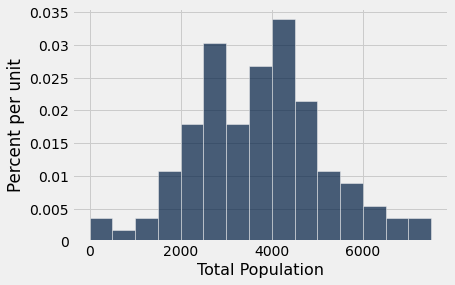

In [ ]:
oakland.hist("Total Population", bins=np.arange(0, 8000, 500))

Q: Looking back at the definition of census tracts, does the distribution of total population make sense? Why or why not?
Hint: The histogram is using each tract as an observation.

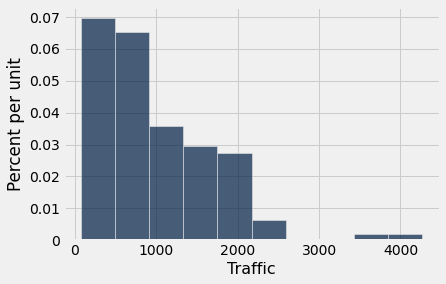

In [ ]:
oakland.hist("Traffic")

*Connect to definition of traffic, and why we may be seeing this distribution. Additionally, why might oakland see such a distribution?*

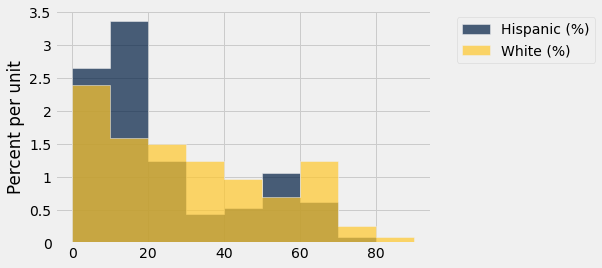

In [ ]:
oakland.hist("Hispanic (%)", "White (%)", bins=np.arange(0, 100, 10))

### Spatial Analysis

By layering spatial data together we are creating a model of the real world. As the data scientist you 


SOMETHING ABOUT SPATIAL DATA
Predictive crime models, some additional resources 


---



In [ ]:
#use geopandas to read in the shapefile that contains the polygons representing census tracts
tracts = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/ALPR/Alameda_CTracts.shp")

In [57]:
tracts.dtypes

STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

This dataset includes only the polygons for 2010 census tracts. To visialize the data collected for these tracts we will have to join the table to the polygons using the tract ID.

In [54]:
#column names must match could switch either
oak = oakland.to_df()

In [65]:
oak = oak.rename(columns={'Census Tract':'GEOID'})

In [61]:
type(oak)

pandas.core.frame.DataFrame

In [66]:
oak['GEOID'] = oak['GEOID'].astype('|S') # which will by default set the length to the max len it encounters


In [68]:
from pickle import FALSE
oak.duplicated(subset='GEOID', keep = False)


0      False
1      False
2      False
3      False
4      False
       ...  
108    False
109    False
110    False
111    False
112    False
Length: 113, dtype: bool

In [56]:
#add leading 0 to tabular data column to, does not work

#oak = oak["Census Tract"].str.zfill(11)

AttributeError: ignored

In [69]:
# Merge with `merge` method on shared variable (Census tract):
oak_shapes = tracts.merge(oak, on='GEOID')

In [70]:
oak_shapes

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,Total Population,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%)


In [ ]:
# Needs to get fixed... regardless, we don't expect students to understand this and we don't want them to. 
# The following are functions that add to the map functionality and expression.

def get_colors_from_column(tbl, col, include_outliers=False):
    """Assigns each row of the input table to a color based on the value of its percentage column."""
    vmin = min(tbl.column(col))
    vmax = max(tbl.column(col))

    if include_outliers:
        outlier_min_bound = vmin
        outlier_max_bound = vmax
    else:
        q1 = np.percentile(tbl.column(col), 25)
        q3 = np.percentile(tbl.column(col), 75)
        IQR = q3 - q1
        outlier_min_bound = max(vmin, q1 - 1.5 * IQR)
        outlier_max_bound = min(vmax, q3 + 1.5 * IQR)
        
    colorbar_scale = list(np.linspace(outlier_min_bound, outlier_max_bound, 10))
    scale_colors = ['#006100', '#3c8000', '#6ba100', '#a3c400', '#dfeb00', '#ffea00', '#ffbb00', '#ff9100', '#ff6200', '#ff2200']
    
    def assign_color(colors, cutoffs, datapoint):
        """Assigns a color to the input percent based on the data's distribution."""
        for i, cutoff in enumerate(cutoffs):
            if cutoff >= datapoint:
                return colors[i - 1] if i > 0 else colors[0]
        return colors[-1]
    
    colors = [""] * tbl.num_rows
    for i, datapoint in enumerate(tbl.column(col)): 
        colors[i] = assign_color(scale_colors, colorbar_scale, datapoint)
        
    return colors

In [ ]:
# Needs to be fixed... ideally clicking on a dot should present 'text' as shown in tbl line.
# The idea is that the other features and information are present (e.g., population demographics, pop size).

def map_feature(feature):
    
    colors = get_colors_from_column(oakland, feature, include_outliers=True) # Get colors based on percentiles
    
    # Note: normalize data then scale to increase
    factor = np.linalg.norm(oakland.column(feature))
    areas = (oakland.column(feature) / factor) * 10000
    
    tbl = oakland.select('Latitude', 'Longitude').with_columns('type', 'text', 'colors', colors, 'areas', areas)
    
    return tbl

In [ ]:
size_map(map_feature('Hispanic (%)'))

In [ ]:
size_map(map_feature('Traffic'))

## 5. Intersectional Analysis

An intersectional analysis between indicators, demographics, and space is important to...

*INCLDUE MAPS HERE*

**Q5a:** Which census tracts seem to be the most heavily surveilled? Which census tracts seem to be the least surveilled?

*Answer here*

**Q5b:** Take a look at the demographic data for the census tracts with high and low surveillance. Considering what you have learned about the history of surveillance on low-income, minority communities, do the patterns revealed by matching census tracts demographic data to the map surprise you? Why or why not?

*Answer here*

**Q5c:** How does the idea of ALPR data being used to help ‘fight crime’ connect with your findings from the map when race and class data are considered?

*Answer here*

## 6. Final Thoughts